# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\Alex MGG\Documents\ICAI\1ºMaster\Etica y explicabilidad\Explicabilidad\Practicas\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

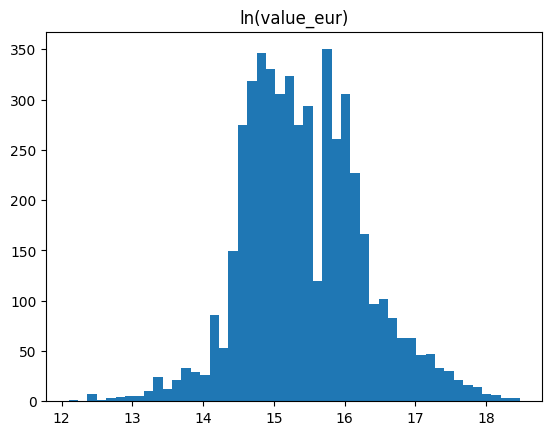

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [6]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [9]:
# Score on train set
train_score = model.score(X_train, ylog_train)

# Score on test set
test_score = model.score(X_test, ylog_test)

print(f"Score train: {train_score:.3f}")
print(f"Score test: {test_score:.3f}")

Score train: 0.997
Score test: 0.926


>>> Aparentemente el modelo no está sobreajustado ya que a pesar de tener una puntuación casi perfecta en el conjunto de entrenamiento, la puntuación en el conjunto de prueba es también bastante alta, lo que significa que el modelo ha generalizado bien.

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [10]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

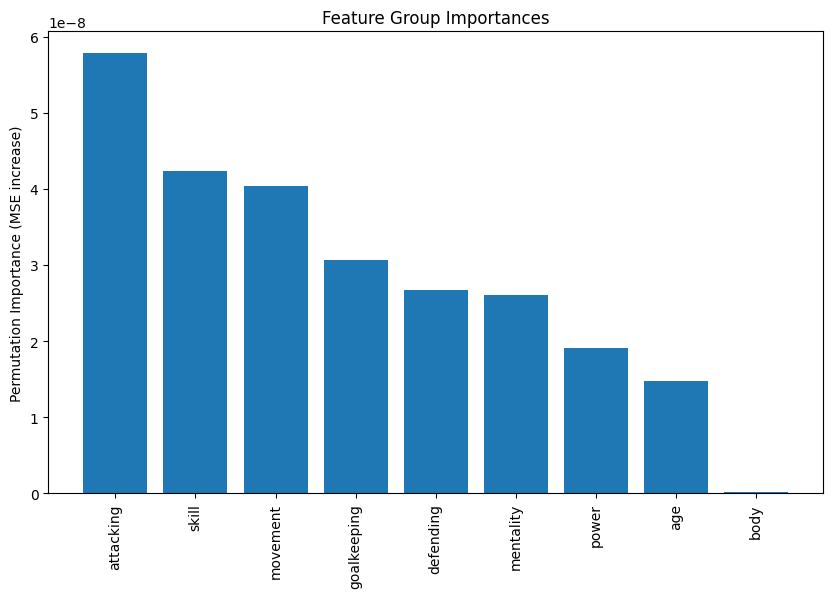

In [24]:
# Compute permutation importances
perm_imp = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=42
)

importances = {}
for group_name, features in variable_groups.items():
    group_importance = np.sum([perm_imp.importances_mean[X_test.columns.get_loc(feat)] for feat in features])
    importances[group_name] = group_importance

# Sort importances
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

# Plot importances
plt.figure(figsize=(10,6))
plt.bar(importances.keys(), importances.values())
plt.ylabel("Permutation Importance (MSE increase)")
plt.title("Feature Group Importances")
plt.xticks(rotation=90)
plt.show()


---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

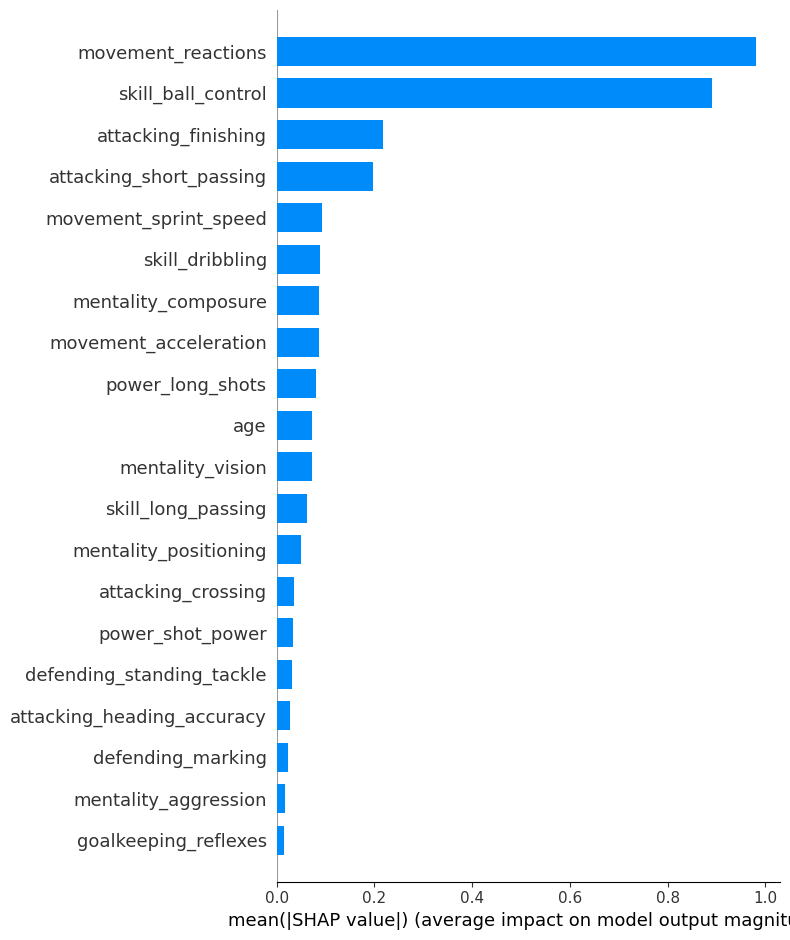

In [ ]:
# Identify row that refers to Lionel Messi
messi_row = df[df['short_name'] == 'L. Messi']
messi_row = messi_row[X_test.columns]  # Keep only feature columns

# Explain prediction for Messi using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(messi_row)

shap.initjs()

shap.summary_plot(shap_values, messi_row, plot_type="bar")

>>> El método usado para obtener la importancia de la variable para el valor de Leo Messi es SHAP (SHapley Additive exPlanations). Este método nos permite entender la contribución de cada característica a la predicción realizada por el modelo para una instancia específica, en este caso, Leo Messi. Los resultados muestran que la variable más influyente para el valor predicho de Messi es "movement_reactions", seguida de cerca por "skill_ball_control".

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

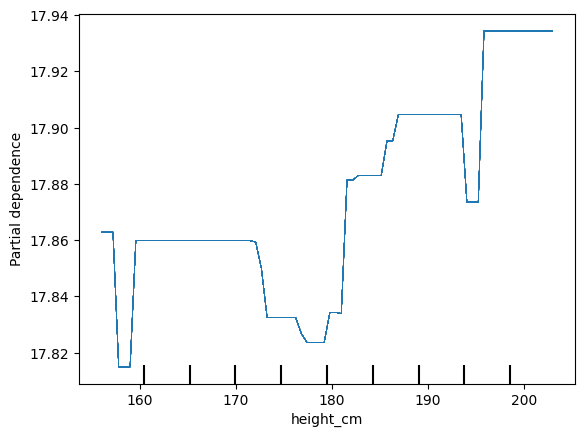

In [43]:
cristiano_row = df[df['short_name'] == 'Cristiano Ronaldo']
cristiano_row = cristiano_row[X_test.columns]  # Keep only feature columns

# Use partial dependence display to analyze the effect of height_cm on the prediction for Cristiano Ronaldo
feature = 'height_cm'
feature_values = np.linspace(np.min(X[feature]), np.max(X[feature]), num=80)

cristiano_df = pd.DataFrame(np.repeat(cristiano_row.values, feature_values.shape[0], axis=0), columns=X_test.columns)
cristiano_df[feature] = feature_values

PartialDependenceDisplay.from_estimator(model, cristiano_df, [feature], kind='individual') #kind='both' if you also want the ICE plots

>>> Se ha usado el método de Partial Dependence Plot (PDP) en modo individual, que realmente saca una gráfica de ICE (Individual Conditional Expectation). La gráfica muestra cómo varía la predicción del valor de Cristiano Ronaldo al cambiar su altura (`height_cm`), manteniendo todas las demás características constantes. En este caso, se observa que para alturas más pequeñas, el valor predicho es más bajo, y con alturas más altas, el valor predicho aumenta. Esto indica que la altura tiene un impacto positivo en la predicción del valor de Cristiano Ronaldo según el modelo entrenado.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

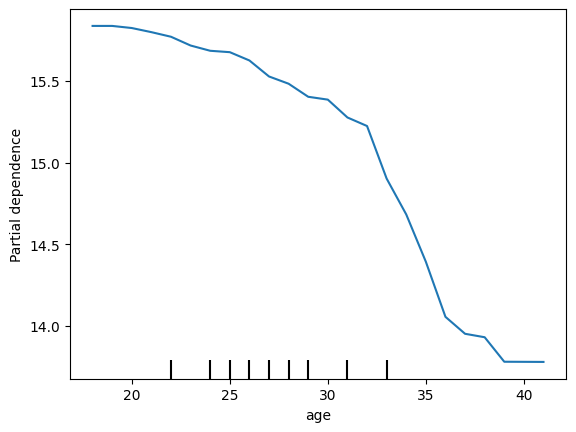

In [44]:
feature = 'age'

PartialDependenceDisplay.from_estimator(model, X_test, [feature], kind='average')

>>> Como se puede observar en la gráfica de Partial Dependence Plot (PDP) para la variable `age`, hay una tendencia clara en cómo la edad afecta las predicciones del modelo. En general, el valor predicho tiende a disminuir a medida que aumenta la edad, lo que indica que los jugadores más jóvenes son valorados más alto en este modelo.

In [67]:
strikers_mask = df["attacking_finishing"] > 80
strikers = df[strikers_mask]
strikers = strikers[X_test.columns]
print(f"Found {strikers.shape[0]} players with finishing > 80 (strikers)")

goalies_mask = df["goalkeeping_diving"] > 80
goalies = df[goalies_mask]
goalies = goalies[X_test.columns]
print(f"Found {goalies.shape[0]} players with diving > 80 (goalkeepers)")

Found 135 players with finishing > 80 (strikers)
Found 62 players with diving > 80 (goalkeepers)


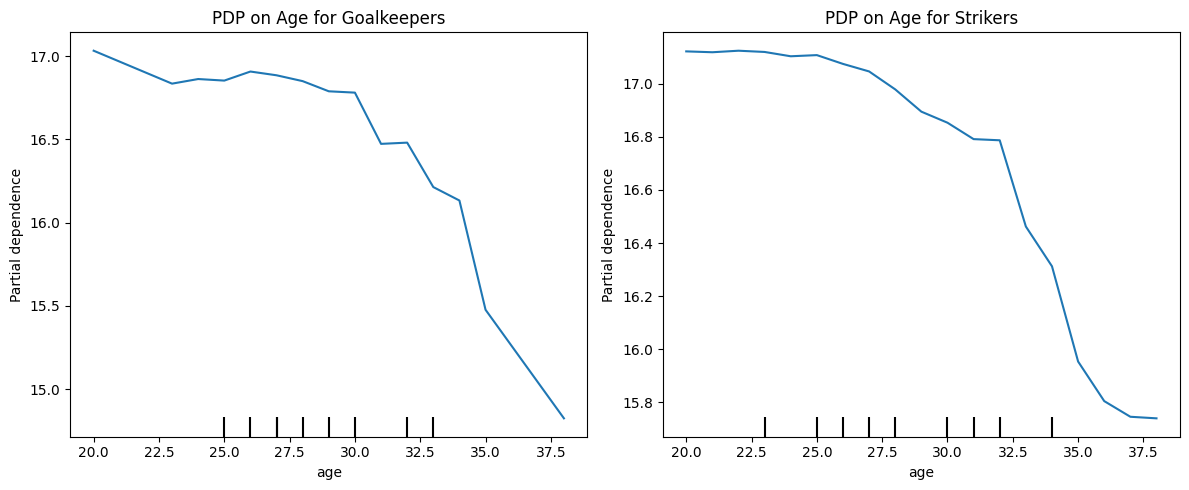

In [72]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

fig1 = PartialDependenceDisplay.from_estimator(model, goalies, [feature], kind='average', ax=ax[0])

fig2 = PartialDependenceDisplay.from_estimator(model, strikers, [feature], kind='average', ax=ax[1])

ax[0].set_title("PDP on Age for Goalkeepers")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Predicted log(value_eur)")

ax[1].set_title("PDP on Age for Strikers")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Predicted log(value_eur)")

plt.tight_layout()
plt.show()

>>> Podemos apreciar que el efecto de la edad sobre el valor de los jugadores es similar en el sentido de que ambos tipos de jugadores (porteros y delanteros) muestran una disminución en el valor predicho a medida que aumenta la edad. Sin embargo, se ve que los porteros tienen un valor predicho menor que el de los delanteros en todas las edades, lo que sugiere que se debe tener en cuenta también la posición del jugador al analizar el impacto de la edad en el valor predicho.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [78]:
from lime.lime_tabular import LimeTabularExplainer

# Identify row that refers to E. Hazard
hazard_row = df[df['short_name'] == 'E. Hazard']
hazard_row = hazard_row[X_test.columns]  # Keep only feature columns

# Define LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_test.columns,
    mode='regression',
    random_state=42
)

# Explain prediction for E. Hazard using LIME
exp = explainer.explain_instance(
    data_row=hazard_row.values[0],
    predict_fn=model.predict,
    num_features=10
)

# Show LIME explanation
exp.show_in_notebook(show_table=True)

>>> Como podemos apreciar, el modelo LIME identifica que el valor de Eden Hazard está principalmente influenciado por variables relacionadas con el ataque, lo cual tiene sentido ya que es un delantero.